In [167]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os, re
import pandas as pd

In [168]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 30})
plt.rc('font', family='serif', serif='Times')

In [169]:
# written with Gemini 3
def get_influence_matrix(log_path):
	with open(log_path, 'r') as f:
		lines = f.readlines()
	
	start_index = -1
	for i, line in enumerate(lines):
		if "6) Influence Graph (aggregated counts):" in line:
			start_index = i
			break
			
	if start_index == -1:
		raise ValueError("Influence Graph not found in log file")
		
	# Skip header and column names (2 lines)
	# The user mentioned parsing the next 31 lines, which likely includes the header/column lines or the data lines.
	# We will parse until we stop finding matching lines.
	data_lines = lines[start_index+2:]
	
	parsed_data = []
	# Regex to capture: index, source, target, count
	# Example: 0       llama1b      llama3b                8
	pattern = re.compile(r'^\s*\d+\s+(\S+)\s+(\S+)\s+(\d+)')
	
	for line in data_lines:
		match = pattern.match(line)
		if match:
			parsed_data.append({
				'source': match.group(1),
				'target': match.group(2),
				'count': int(match.group(3))
			})
		else:
			# Stop if we hit a line that doesn't match (end of table)
			if len(parsed_data) > 0:
				break
				
	df = pd.DataFrame(parsed_data)
	
	# Get all unique models
	models = sorted(list(set(df['source'].unique()) | set(df['target'].unique())))
	
	# Create matrix initialized with NaNs
	matrix = pd.DataFrame(np.nan, index=models, columns=models)
	
	for _, row in df.iterrows():
		matrix.loc[row['source'], row['target']] = row['count']

	# move qwen14 to the last row and column (you are guaranteed to have it)
	print(matrix.index)
	if 'qwen14b' in matrix.index:
		matrix = matrix.reindex(index=[m for m in models if m != 'qwen14b'] + ['qwen14b'],
		                        columns=[m for m in models if m != 'qwen14b'] + ['qwen14b'])
		
	return matrix

def plot_influence_matrix(matrix, title, output_path):
	plt.figure(figsize=(12, 12))
	sns.heatmap(
		matrix, 
		annot=True, 
		fmt=".0f",
		cmap="magma",           # <--- Deep blacks/purples to bright yellows
		cbar_kws={'label': 'Influence Count'}, 
		linewidths=1, 
		linecolor='white',      # Dark lines for contrast
		annot_kws={"size": 30, "weight": "bold"},
		square=True
	)
	# plt.title(title)
	plt.xlabel('Target', fontsize=50, labelpad=10)
	plt.ylabel('Source', fontsize=50, labelpad=10)
	plt.xticks(rotation=90)
	plt.yticks(rotation=0)
	plt.tight_layout()
	plt.savefig(output_path, bbox_inches="tight", dpi=300)

In [170]:
def process_graph(log_file_path, title, output_path):
	if os.path.exists(log_file_path):
		influence_matrix = get_influence_matrix(log_file_path)
		print("Influence Matrix:")
		print(influence_matrix)
		plot_influence_matrix(influence_matrix, title, output_path)
		plt.show()
	else:
		print(f"File not found: {log_file_path}")

Index(['llama1b', 'llama3b', 'llama8b', 'qwen14b', 'qwen3b', 'qwen7b'], dtype='object')
Influence Matrix:
         llama1b  llama3b  llama8b  qwen3b  qwen7b  qwen14b
llama1b      NaN      8.0     51.0    41.0    25.0     25.0
llama3b     24.0      NaN     47.0    35.0    27.0     29.0
llama8b     35.0     27.0      NaN    70.0    36.0     34.0
qwen3b      29.0     34.0     51.0     NaN    55.0     34.0
qwen7b      34.0     27.0     53.0    57.0     NaN     26.0
qwen14b     32.0     34.0     54.0    50.0    38.0      NaN


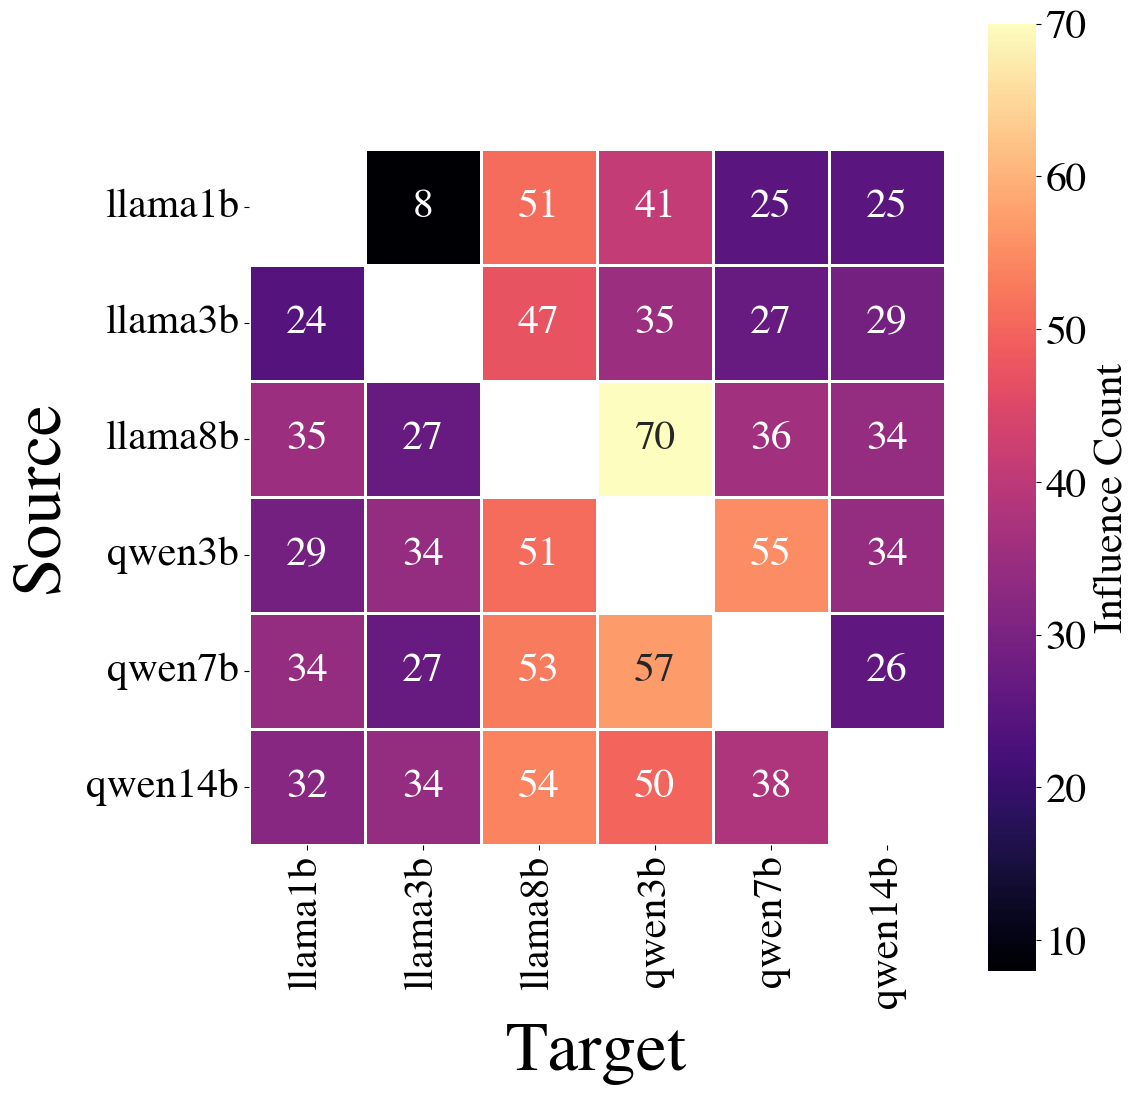

In [173]:
expt_name = "dss_0.5_0"
log_file_path = f'eval_results/mmlu_debate_metadata_{expt_name}__EVAL/log.txt'
import os
os.makedirs('images', exist_ok=True)
process_graph(log_file_path, expt_name, f"images/interaction_heatmap_{expt_name}.png")

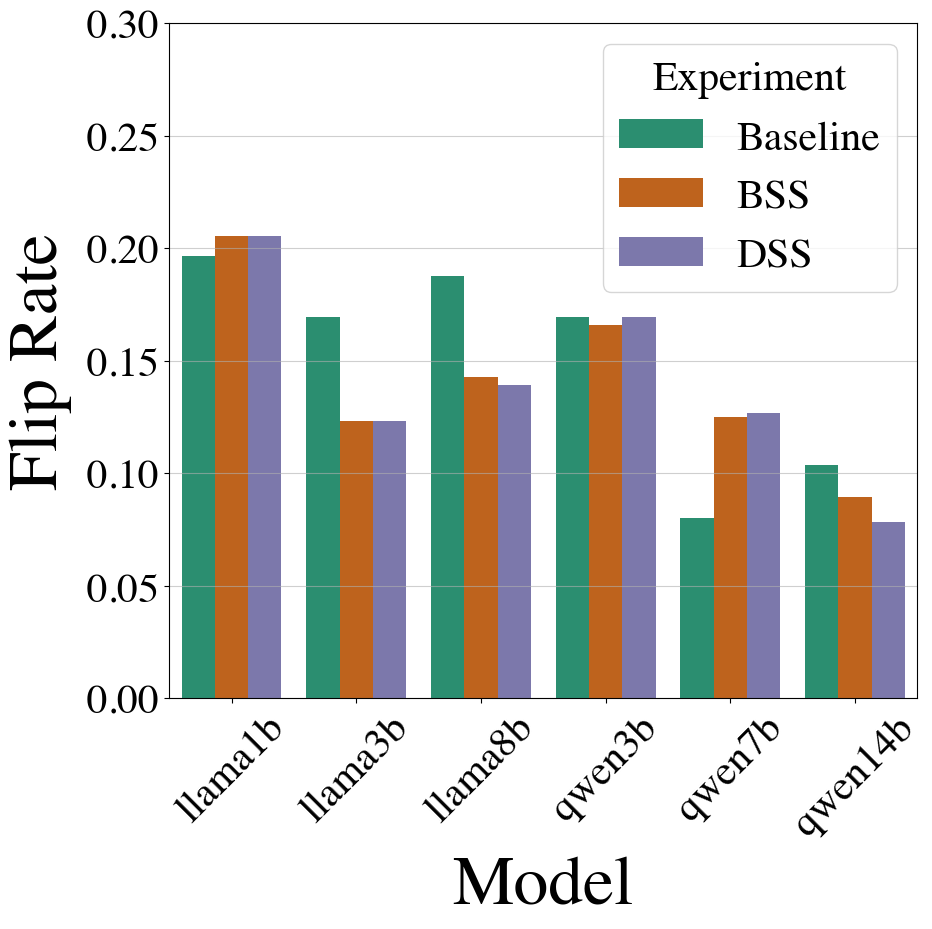

In [180]:
def get_flip_rates(log_path):
    with open(log_path, 'r') as f:
        lines = f.readlines()
    
    start_index = -1
    for i, line in enumerate(lines):
        if "4) Flip Rate (per model):" in line:
            start_index = i
            break
            
    if start_index == -1:
        print(f"Warning: Flip Rate section not found in {log_path}")
        return pd.DataFrame()
        
    # Skip header (2 lines: title and column headers)
    data_lines = lines[start_index+2:]
    
    parsed_data = []
    # Regex to capture: index, model, num_flips, flip_rate
    pattern = re.compile(r'^\s*\d+\s+(\S+)\s+(\S+)\s+(\S+)')
    
    for line in data_lines:
        match = pattern.match(line)
        if match:
            parsed_data.append({
                'model': match.group(1),
                'flip_rate': float(match.group(3))
            })
        else:
            # Stop if we hit a line that doesn't match (end of table)
            if len(parsed_data) > 0:
                break
                
    df = pd.DataFrame(parsed_data)
    return df

def plot_flip_rates_comparison(log_files, titles, output_path):
    all_data = []
    
    for log_file, title in zip(log_files, titles):
        if os.path.exists(log_file):
            df = get_flip_rates(log_file)
            if not df.empty:
                df['Experiment'] = title
                all_data.append(df)
        else:
            print(f"File not found: {log_file}")
            
    if not all_data:
        print("No data to plot.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)
    
    plt.figure(figsize=(10, 10))
    
    # Define custom order
    custom_order = ['llama1b', 'llama3b', 'llama8b', 'qwen3b', 'qwen7b', 'qwen14b']
    
    # Ensure we handle models not in the list if any exist
    existing_models = set(combined_df['model'].unique())
    ordered_models = [m for m in custom_order if m in existing_models]
    remaining_models = sorted(list(existing_models - set(ordered_models)))
    final_order = ordered_models + remaining_models
    
    combined_df['model'] = pd.Categorical(combined_df['model'], categories=final_order, ordered=True)
    combined_df = combined_df.sort_values('model')
    
    COLORS = ['#1b9e77', '#d95f02', '#7570b3']
    sns.barplot(data=combined_df, x='model', y='flip_rate', hue='Experiment', palette=COLORS)
    
    # plt.title('Flip Rate by Model across Experiments')
    plt.xlabel('Model', fontsize=50, labelpad=10)
    plt.ylabel('Flip Rate', fontsize=50, labelpad=10)
    plt.legend(title='Experiment', loc='best')
    plt.grid(axis='y', linestyle='-', alpha=0.6)
    plt.xticks(rotation=45)
    # y axis goes until 0.40 in 0.05 increments
    plt.ylim((0., 0.3))
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()

# Example Usage
# Define your experiments here
experiments = [
    ("Baseline", "eval_results/mmlu_debate_metadata_original__EVAL/log.txt"),
    ("DSS", "eval_results/mmlu_debate_metadata_dss_0.5_0__EVAL/log.txt"),
    ("BSS", "eval_results/mmlu_debate_metadata_bss_only__EVAL/log.txt"),
]

titles = [e[0] for e in experiments]
log_files = [e[1] for e in experiments]

plot_flip_rates_comparison(log_files, titles, "images/flip_rate_comparison.png")

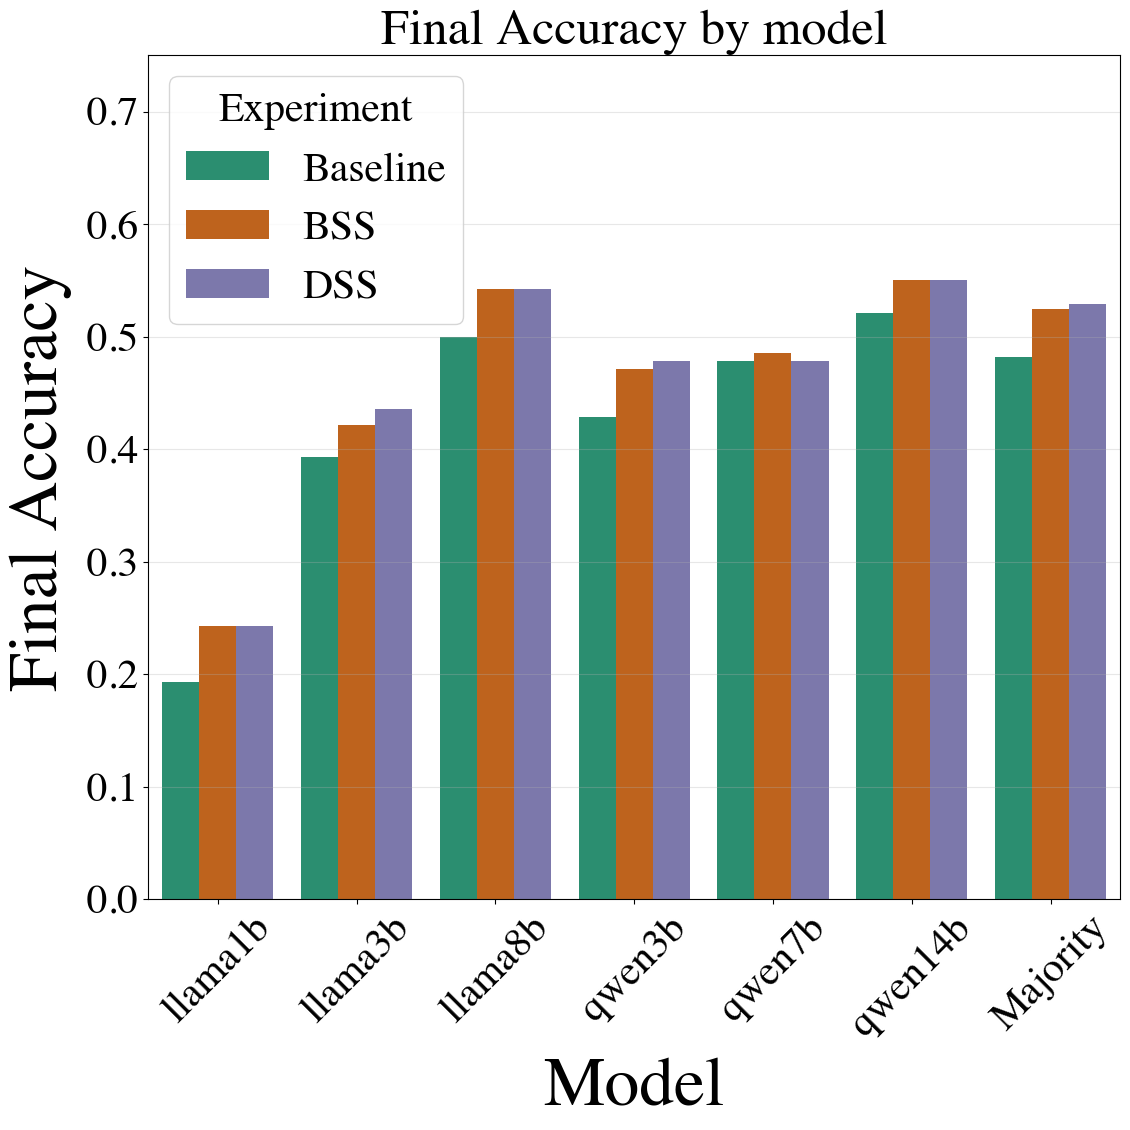

In [196]:
def get_accuracy_metrics(log_path):
    with open(log_path, 'r') as f:
        lines = f.readlines()
    
    majority_correctness = None
    individual_accuracy_df = pd.DataFrame()
    
    # Parse Final Majority Correctness
    for i, line in enumerate(lines):
        if "1) Final Majority Correctness:" in line:
            # Next line looks like: "   73/139 = 0.525"
            if i + 1 < len(lines):
                parts = lines[i+1].split('=')
                if len(parts) > 1:
                    try:
                        majority_correctness = float(parts[1].strip())
                    except ValueError:
                        pass
            break
            
    # Parse Individual Final Correctness
    start_index = -1
    for i, line in enumerate(lines):
        if "2) Individual Final Correctness (per model):" in line:
            start_index = i
            break
            
    if start_index != -1:
        # Skip header (2 lines: title and column headers)
        data_lines = lines[start_index+2:]
        parsed_data = []
        # Regex: index, model, final_accuracy
        pattern = re.compile(r'^\s*\d+\s+(\S+)\s+(\S+)')
        
        for line in data_lines:
            match = pattern.match(line)
            if match:
                parsed_data.append({
                    'model': match.group(1),
                    'final_accuracy': float(match.group(2))
                })
            else:
                if len(parsed_data) > 0: # Stop if we hit end of table
                    break
        individual_accuracy_df = pd.DataFrame(parsed_data)

    return majority_correctness, individual_accuracy_df

def plot_accuracy_comparison(log_files, titles, output_path_prefix):
    all_data = []
    
    for log_file, title in zip(log_files, titles):
        if os.path.exists(log_file):
            maj_corr, ind_df = get_accuracy_metrics(log_file)
            
            if not ind_df.empty:
                ind_df['Experiment'] = title
                
                # Add Majority as a model
                if maj_corr is not None:
                    maj_row = pd.DataFrame([{'model': 'Majority', 'final_accuracy': maj_corr, 'Experiment': title}])
                    ind_df = pd.concat([ind_df, maj_row], ignore_index=True)
                
                all_data.append(ind_df)
        else:
            print(f"File not found: {log_file}")
            
    COLORS = ['#1b9e77', '#d95f02', '#7570b3']

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        
        # Define custom order
        custom_order = ['llama1b', 'llama3b', 'llama8b', 'qwen3b', 'qwen7b', 'qwen14b']
        
        # Get existing models excluding Majority
        existing_models = set(combined_df['model'].unique()) - {'Majority'}
        
        # Create ordered list based on custom_order
        ordered_models = [m for m in custom_order if m in existing_models]
        
        # Add any remaining models that weren't in custom_order
        remaining_models = sorted(list(existing_models - set(ordered_models)))
        final_order = ordered_models + remaining_models
        
        # Append Majority at the end if it exists
        if 'Majority' in combined_df['model'].values:
            final_order.append('Majority')
            
        combined_df['model'] = pd.Categorical(combined_df['model'], categories=final_order, ordered=True)
        combined_df = combined_df.sort_values('model')
        
        plt.figure(figsize=(12, 12))
        sns.barplot(data=combined_df, x='model', y='final_accuracy', hue='Experiment', palette=COLORS)
        
        plt.title('Final Accuracy by model')
        plt.xlabel('Model', fontsize=50, labelpad=10)
        plt.ylabel('Final Accuracy', fontsize=50, labelpad=10)
        plt.legend(title='Experiment', loc='best')
        plt.grid(axis='y', linestyle='-', alpha=0.3)
        plt.xticks(rotation=45)
        plt.ylim((0., 0.75))
        plt.tight_layout()
        
        if output_path_prefix:
            plt.savefig(f"{output_path_prefix}_combined.png", bbox_inches="tight", dpi=300)
        plt.show()

# Example Usage
experiments = [
    ("Baseline", "eval_results/mmlu_debate_metadata_original__EVAL/log.txt"),
    ("BSS", "eval_results/mmlu_debate_metadata_bss_only__EVAL/log.txt"),
    ("DSS", "eval_results/mmlu_debate_metadata_dss_0.5_0__EVAL/log.txt"),
]

titles = [e[0] for e in experiments]
log_files = [e[1] for e in experiments]

plot_accuracy_comparison(log_files, titles, "images/accuracy_comparison")

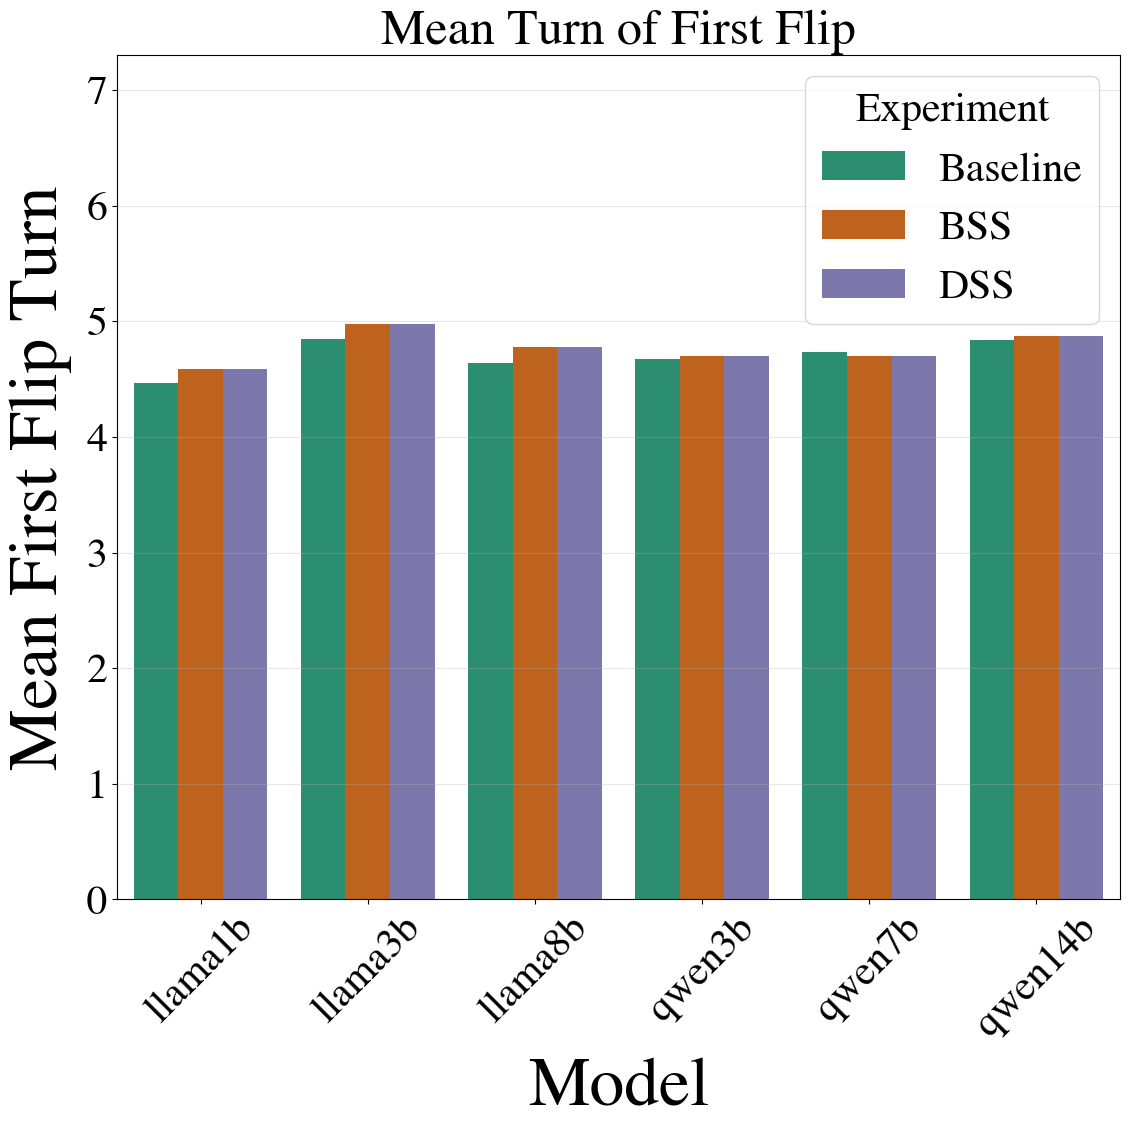

In [195]:
def get_first_flip_turns(log_path):
    with open(log_path, 'r') as f:
        lines = f.readlines()
    
    start_index = -1
    for i, line in enumerate(lines):
        if "5) Turn of First Flip from Correct -> User's Wrong Answer" in line:
            start_index = i
            break
            
    if start_index == -1:
        print(f"Warning: First Flip Turn section not found in {log_path}")
        return pd.DataFrame()
        
    # Skip header (2 lines: title and column headers)
    data_lines = lines[start_index+2:]
    
    parsed_data = []
    # Regex to capture: index, model, first_correct_to_user_flip
    pattern = re.compile(r'^\s*\d+\s+(\S+)\s+(\S+)')
    
    for line in data_lines:
        match = pattern.match(line)
        if match:
            val_str = match.group(2)
            # Handle NaN or valid float
            try:
                val = float(val_str)
            except ValueError:
                val = float('nan')
                
            parsed_data.append({
                'model': match.group(1),
                'first_flip_turn': val
            })
        else:
            # Stop if we hit a line that doesn't match (end of table)
            if len(parsed_data) > 0:
                break
                
    df = pd.DataFrame(parsed_data)
    return df

def plot_first_flip_comparison(log_files, titles, output_path):
    all_data = []
    
    for log_file, title in zip(log_files, titles):
        if os.path.exists(log_file):
            df = get_first_flip_turns(log_file)
            if not df.empty:
                df['Experiment'] = title
                all_data.append(df)
        else:
            print(f"File not found: {log_file}")
            
    if not all_data:
        print("No data to plot.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)
    
    plt.figure(figsize=(12, 12))
    
    # Define custom order
    custom_order = ['llama1b', 'llama3b', 'llama8b', 'qwen3b', 'qwen7b', 'qwen14b']
    
    # Ensure we handle models not in the list if any exist
    existing_models = set(combined_df['model'].unique())
    ordered_models = [m for m in custom_order if m in existing_models]
    remaining_models = sorted(list(existing_models - set(ordered_models)))
    final_order = ordered_models + remaining_models
    
    combined_df['model'] = pd.Categorical(combined_df['model'], categories=final_order, ordered=True)
    combined_df = combined_df.sort_values('model')
    
    COLORS = ['#1b9e77', '#d95f02', '#7570b3']
    sns.barplot(data=combined_df, x='model', y='first_flip_turn', hue='Experiment', palette=COLORS)
    
    plt.title('Mean Turn of First Flip')
    plt.xlabel('Model', fontsize=50, labelpad=10)
    plt.ylabel('Mean First Flip Turn', fontsize=50, labelpad=10)
    plt.legend(title='Experiment', loc='best')
    plt.grid(axis='y', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45)
    plt.ylim((0., 7.3))
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches="tight", dpi=300)
    plt.show()

# Example Usage
experiments = [
    ("Baseline", "eval_results/mmlu_debate_metadata_original__EVAL/log.txt"),
    ("DSS", "eval_results/mmlu_debate_metadata_dss_0.5_0__EVAL/log.txt"),
    ("BSS", "eval_results/mmlu_debate_metadata_bss_only__EVAL/log.txt"),
]

titles = [e[0] for e in experiments]
log_files = [e[1] for e in experiments]

plot_first_flip_comparison(log_files, titles, "images/first_flip_turn_comparison.png")

In [183]:
# Calculate averages by model
def get_flip_analysis_data(df):
    print("Average Flip Statistics by Model:")
    print("=" * 80)

    model_stats = df.groupby('model').agg({
        'flips_toward_user': 'mean',
        'flips_toward_correct': 'mean',
        'flips_toward_majority': 'mean',
        'flips_away_from_correct': 'mean'
    }).round(4)

    # Display results for each model
    for model in model_stats.index:
        print(f"\nModel: {model}")
        print("-" * 80)
        print(f"  Average flips toward user:           {model_stats.loc[model, 'flips_toward_user']:.4f}")
        print(f"  Average flips toward correct answer: {model_stats.loc[model, 'flips_toward_correct']:.4f}")
        print(f"  Average flips toward majority:       {model_stats.loc[model, 'flips_toward_majority']:.4f}")
        print(f"  Average flips away from correct:     {model_stats.loc[model, 'flips_away_from_correct']:.4f}")

    print("\n" + "=" * 80)

    # Also display as a table
    print("\nSummary Table:")
    print(model_stats)
    return model_stats

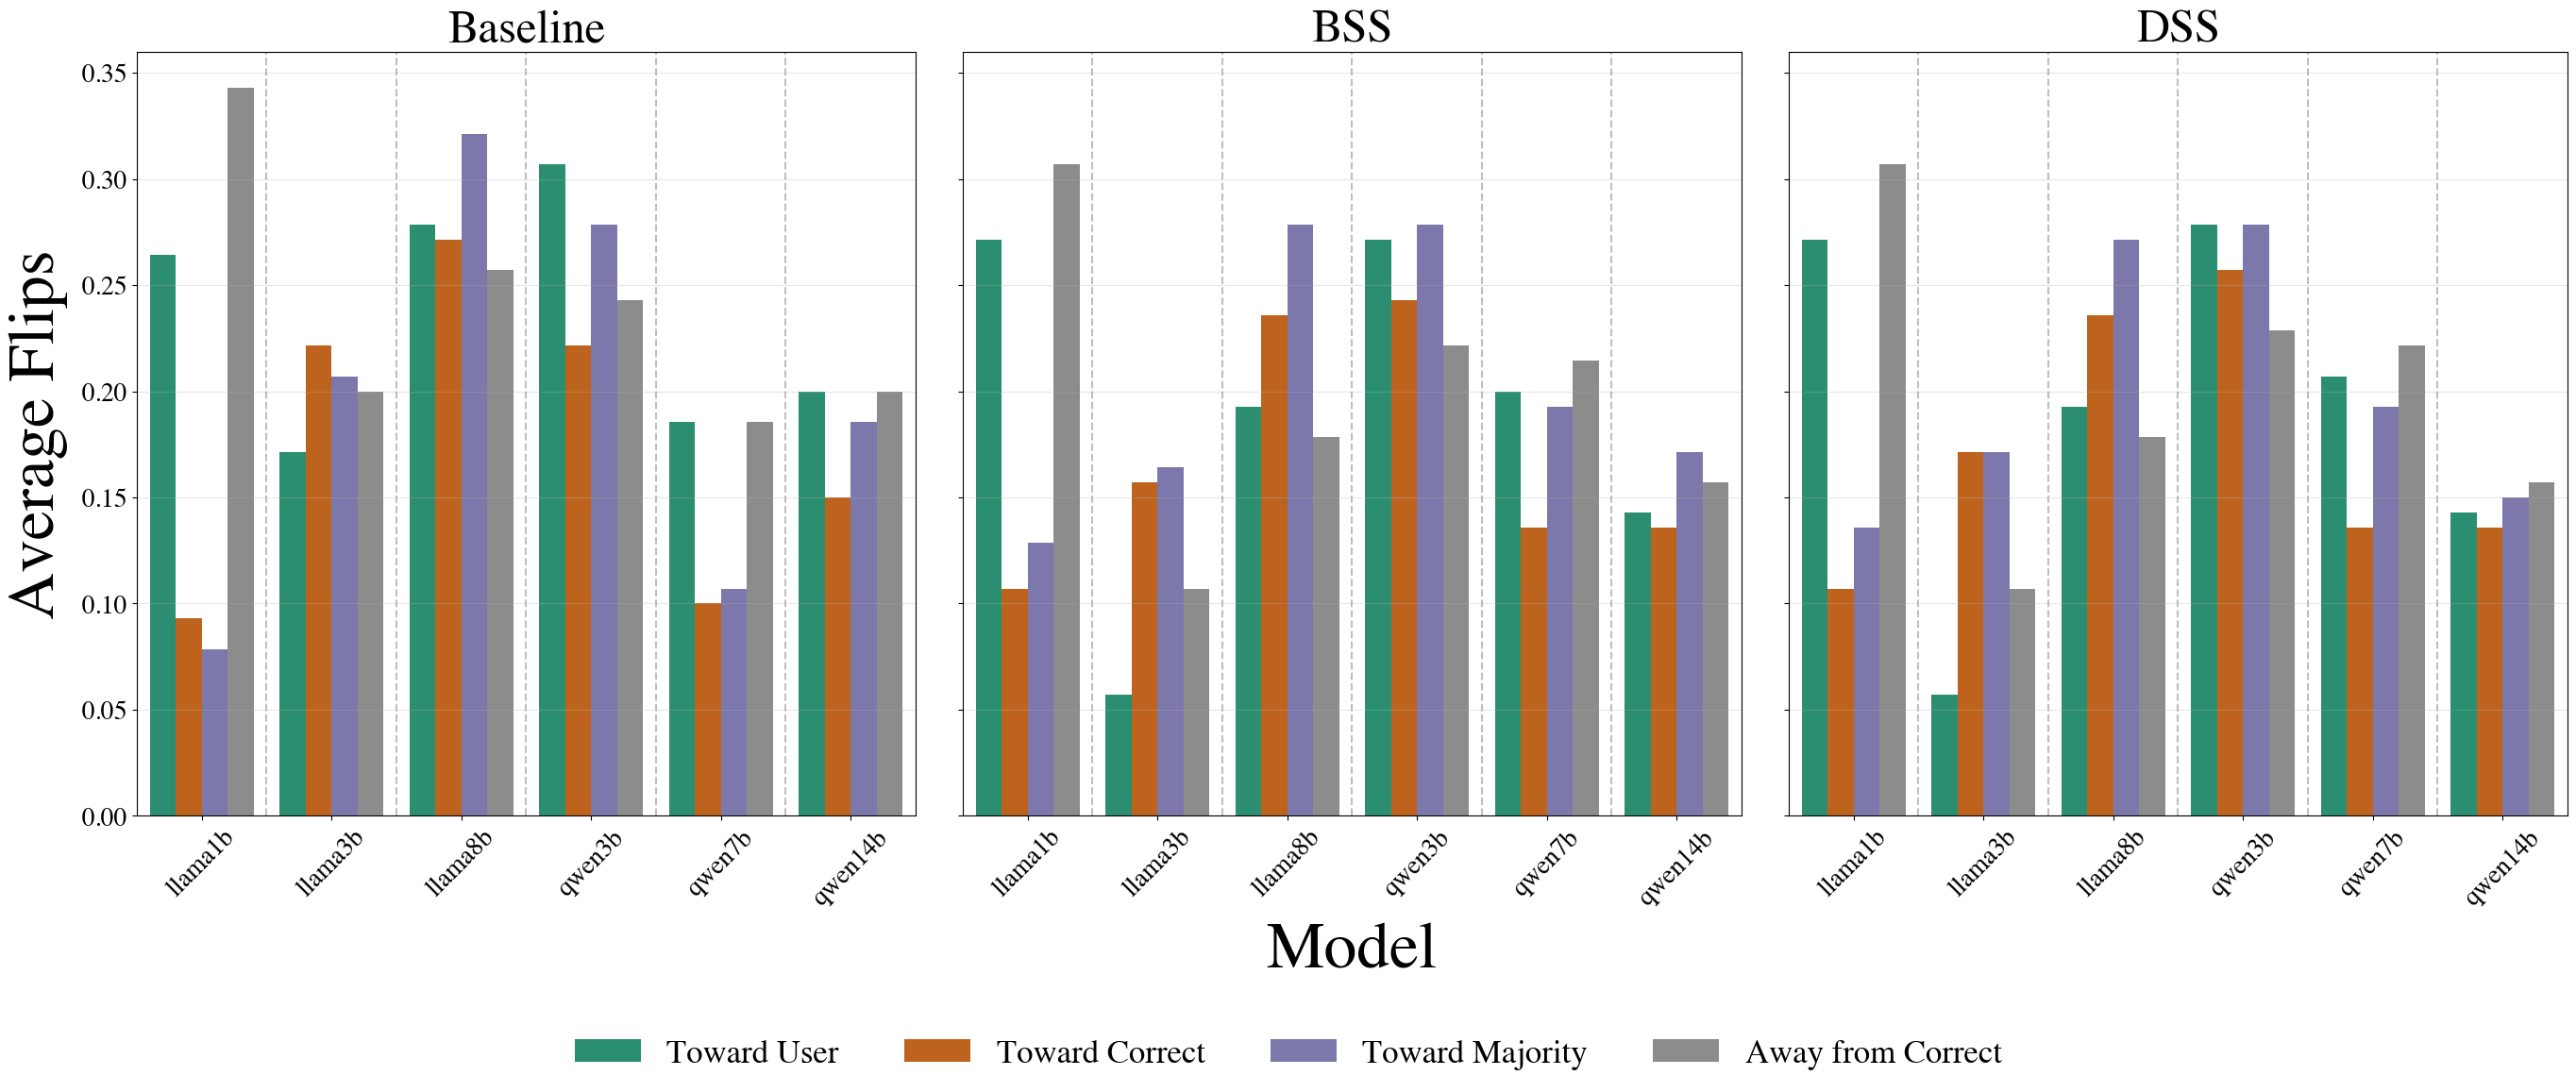

In [186]:
experiments = [
    ("Baseline", "eval_results/mmlu_debate_metadata_original__EVAL/summary_all.csv"),
    ("BSS", "eval_results/mmlu_debate_metadata_bss_only__EVAL/summary_all.csv"),
    ("DSS", "eval_results/mmlu_debate_metadata_dss_0.5_0__EVAL/summary_all.csv"),
]

COLORS_4 = ['#1b9e77', '#d95f02', '#7570b3', '#8c8c8c']
metric_map = {
    'flips_toward_user': 'Toward User',
    'flips_toward_correct': 'Toward Correct',
    'flips_toward_majority': 'Toward Majority',
    'flips_away_from_correct': 'Away from Correct'
}
fig, axes = plt.subplots(1, 3, figsize=(28, 12), sharey=True)

# Define custom order
custom_order = ['llama1b', 'llama3b', 'llama8b', 'qwen3b', 'qwen7b', 'qwen14b']

for i, (name, path) in enumerate(experiments):
    ax = axes[i]
    if os.path.exists(path):
        df = pd.read_csv(path)
        
        # Aggregate stats
        model_stats = df.groupby('model').agg({
            'flips_toward_user': 'mean',
            'flips_toward_correct': 'mean',
            'flips_toward_majority': 'mean',
            'flips_away_from_correct': 'mean'
        }).round(4)
        
        model_stats_reset = model_stats.reset_index()
        
        # Apply custom ordering
        existing_models = set(model_stats_reset['model'].unique())
        ordered_models = [m for m in custom_order if m in existing_models]
        remaining_models = sorted(list(existing_models - set(ordered_models)))
        final_order = ordered_models + remaining_models
        
        model_stats_reset['model'] = pd.Categorical(model_stats_reset['model'], categories=final_order, ordered=True)
        model_stats_reset = model_stats_reset.sort_values('model')
        
        melted_df = model_stats_reset.melt(id_vars='model', 
                                           value_vars=['flips_toward_user', 'flips_toward_correct', 'flips_toward_majority', 'flips_away_from_correct'],
                                           var_name='Metric', 
                                           value_name='Average Flips')
        melted_df['Metric'] = melted_df['Metric'].map(metric_map)
        
        sns.barplot(data=melted_df, x='model', y='Average Flips', hue='Metric', palette=COLORS_4, ax=ax)
        
        # Add vertical lines to separate models
        n_models = len(model_stats_reset['model'].unique())
        for x in range(n_models - 1):
            ax.axvline(x + 0.5, color='gray', linestyle='--', alpha=0.5)
            
        ax.set_title(name, fontsize=35)
        ax.tick_params(axis='x', rotation=45, labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.grid(axis='y', linestyle='-', alpha=0.3)
        
        # X Axis Label (Central only)
        if i == 1:
            ax.set_xlabel('Model', fontsize=50, labelpad=10)
        else:
            ax.set_xlabel('')
            
        # Y Axis Label (Left only)
        if i == 0:
            ax.set_ylabel('Average Flips', fontsize=50, labelpad=10)
        else:
            ax.set_ylabel('')
            
        # Remove individual legends
        if ax.get_legend():
            ax.get_legend().remove()
            
    else:
        ax.text(0.5, 0.5, f"File not found:\n{path}", ha='center', va='center')
        ax.axis('off')

# Global Legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=4, fontsize=25, frameon=False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25) # Make space for legend
plt.savefig("images/flip_direction_comparison_3plots.png", bbox_inches="tight", dpi=300)
plt.show()

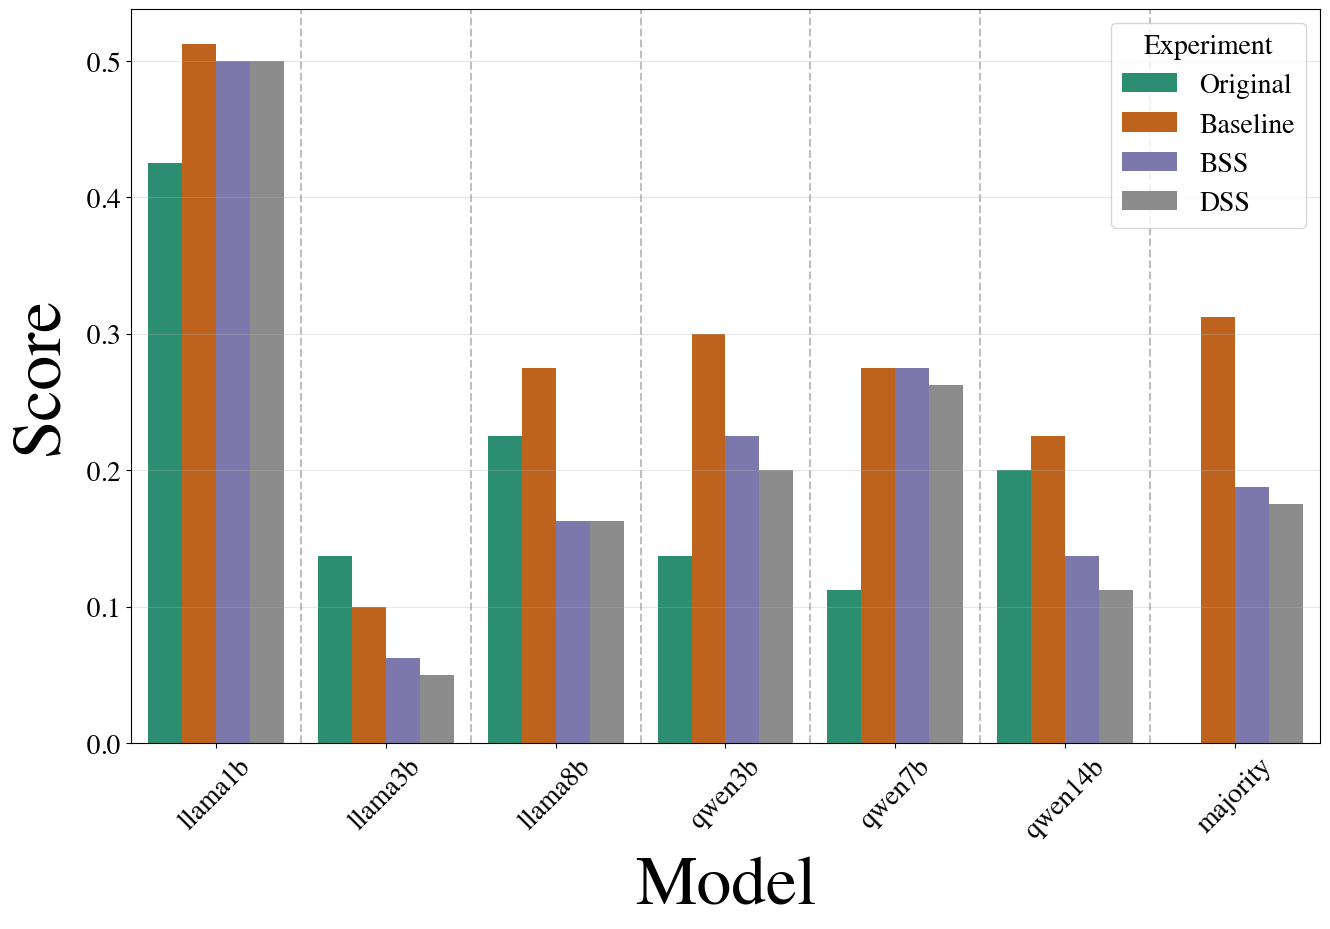

In [190]:
import numpy as np

# Data provided by user
data = {
    'model': ['llama1b', 'llama3b', 'llama8b', 'majority', 'qwen14b', 'qwen3b', 'qwen7b'],
    # 'Original': [0.460, 0.170, 0.250, np.nan, 0.065, 0.220, 0.160],
    'Original': [0.425, 0.1375, 0.225, np.nan, 0.2, 0.1375, 0.1125],
    'Baseline': [0.5125, 0.1000, 0.2750, 0.3125, 0.2250, 0.3000, 0.2750],
    'BSS': [0.5000, 0.0625, 0.1625, 0.1875, 0.1375, 0.2250, 0.2750],
    'DSS': [0.5000, 0.0500, 0.1625, 0.1750, 0.1125, 0.2000, 0.2625]
}

df = pd.DataFrame(data)

# Melt the DataFrame
melted_df = df.melt(id_vars='model', var_name='Experiment', value_name='Score')

# Order models: qwen3b and qwen7b before qwen14b, majority_vote at the end
models_order = ['llama1b', 'llama3b', 'llama8b', 'qwen3b', 'qwen7b', 'qwen14b', 'majority']
melted_df['model'] = pd.Categorical(melted_df['model'], categories=models_order, ordered=True)

# Order experiments: Original, Baseline, BSS, DSS
experiments_order = ['Original', 'Baseline', 'BSS', 'DSS']
melted_df['Experiment'] = pd.Categorical(melted_df['Experiment'], categories=experiments_order, ordered=True)

melted_df = melted_df.sort_values(['model', 'Experiment'])

# Plot
plt.figure(figsize=(14, 10))
COLORS_4 = ['#1b9e77', '#d95f02', '#7570b3', '#8c8c8c']
sns.barplot(data=melted_df, x='model', y='Score', hue='Experiment', palette=COLORS_4)

# plt.title('Performance Comparison')
plt.xlabel('Model', fontsize=50, labelpad=10)
plt.ylabel('Score', fontsize=50, labelpad=10)
plt.legend(title='Experiment', loc='best', fontsize=20, title_fontsize=20)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)

# Add vertical lines
n_models = len(models_order)
for x in range(n_models - 1):
    plt.axvline(x + 0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("images/manual_performance_comparison.png", bbox_inches="tight", dpi=300)
plt.show()